The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


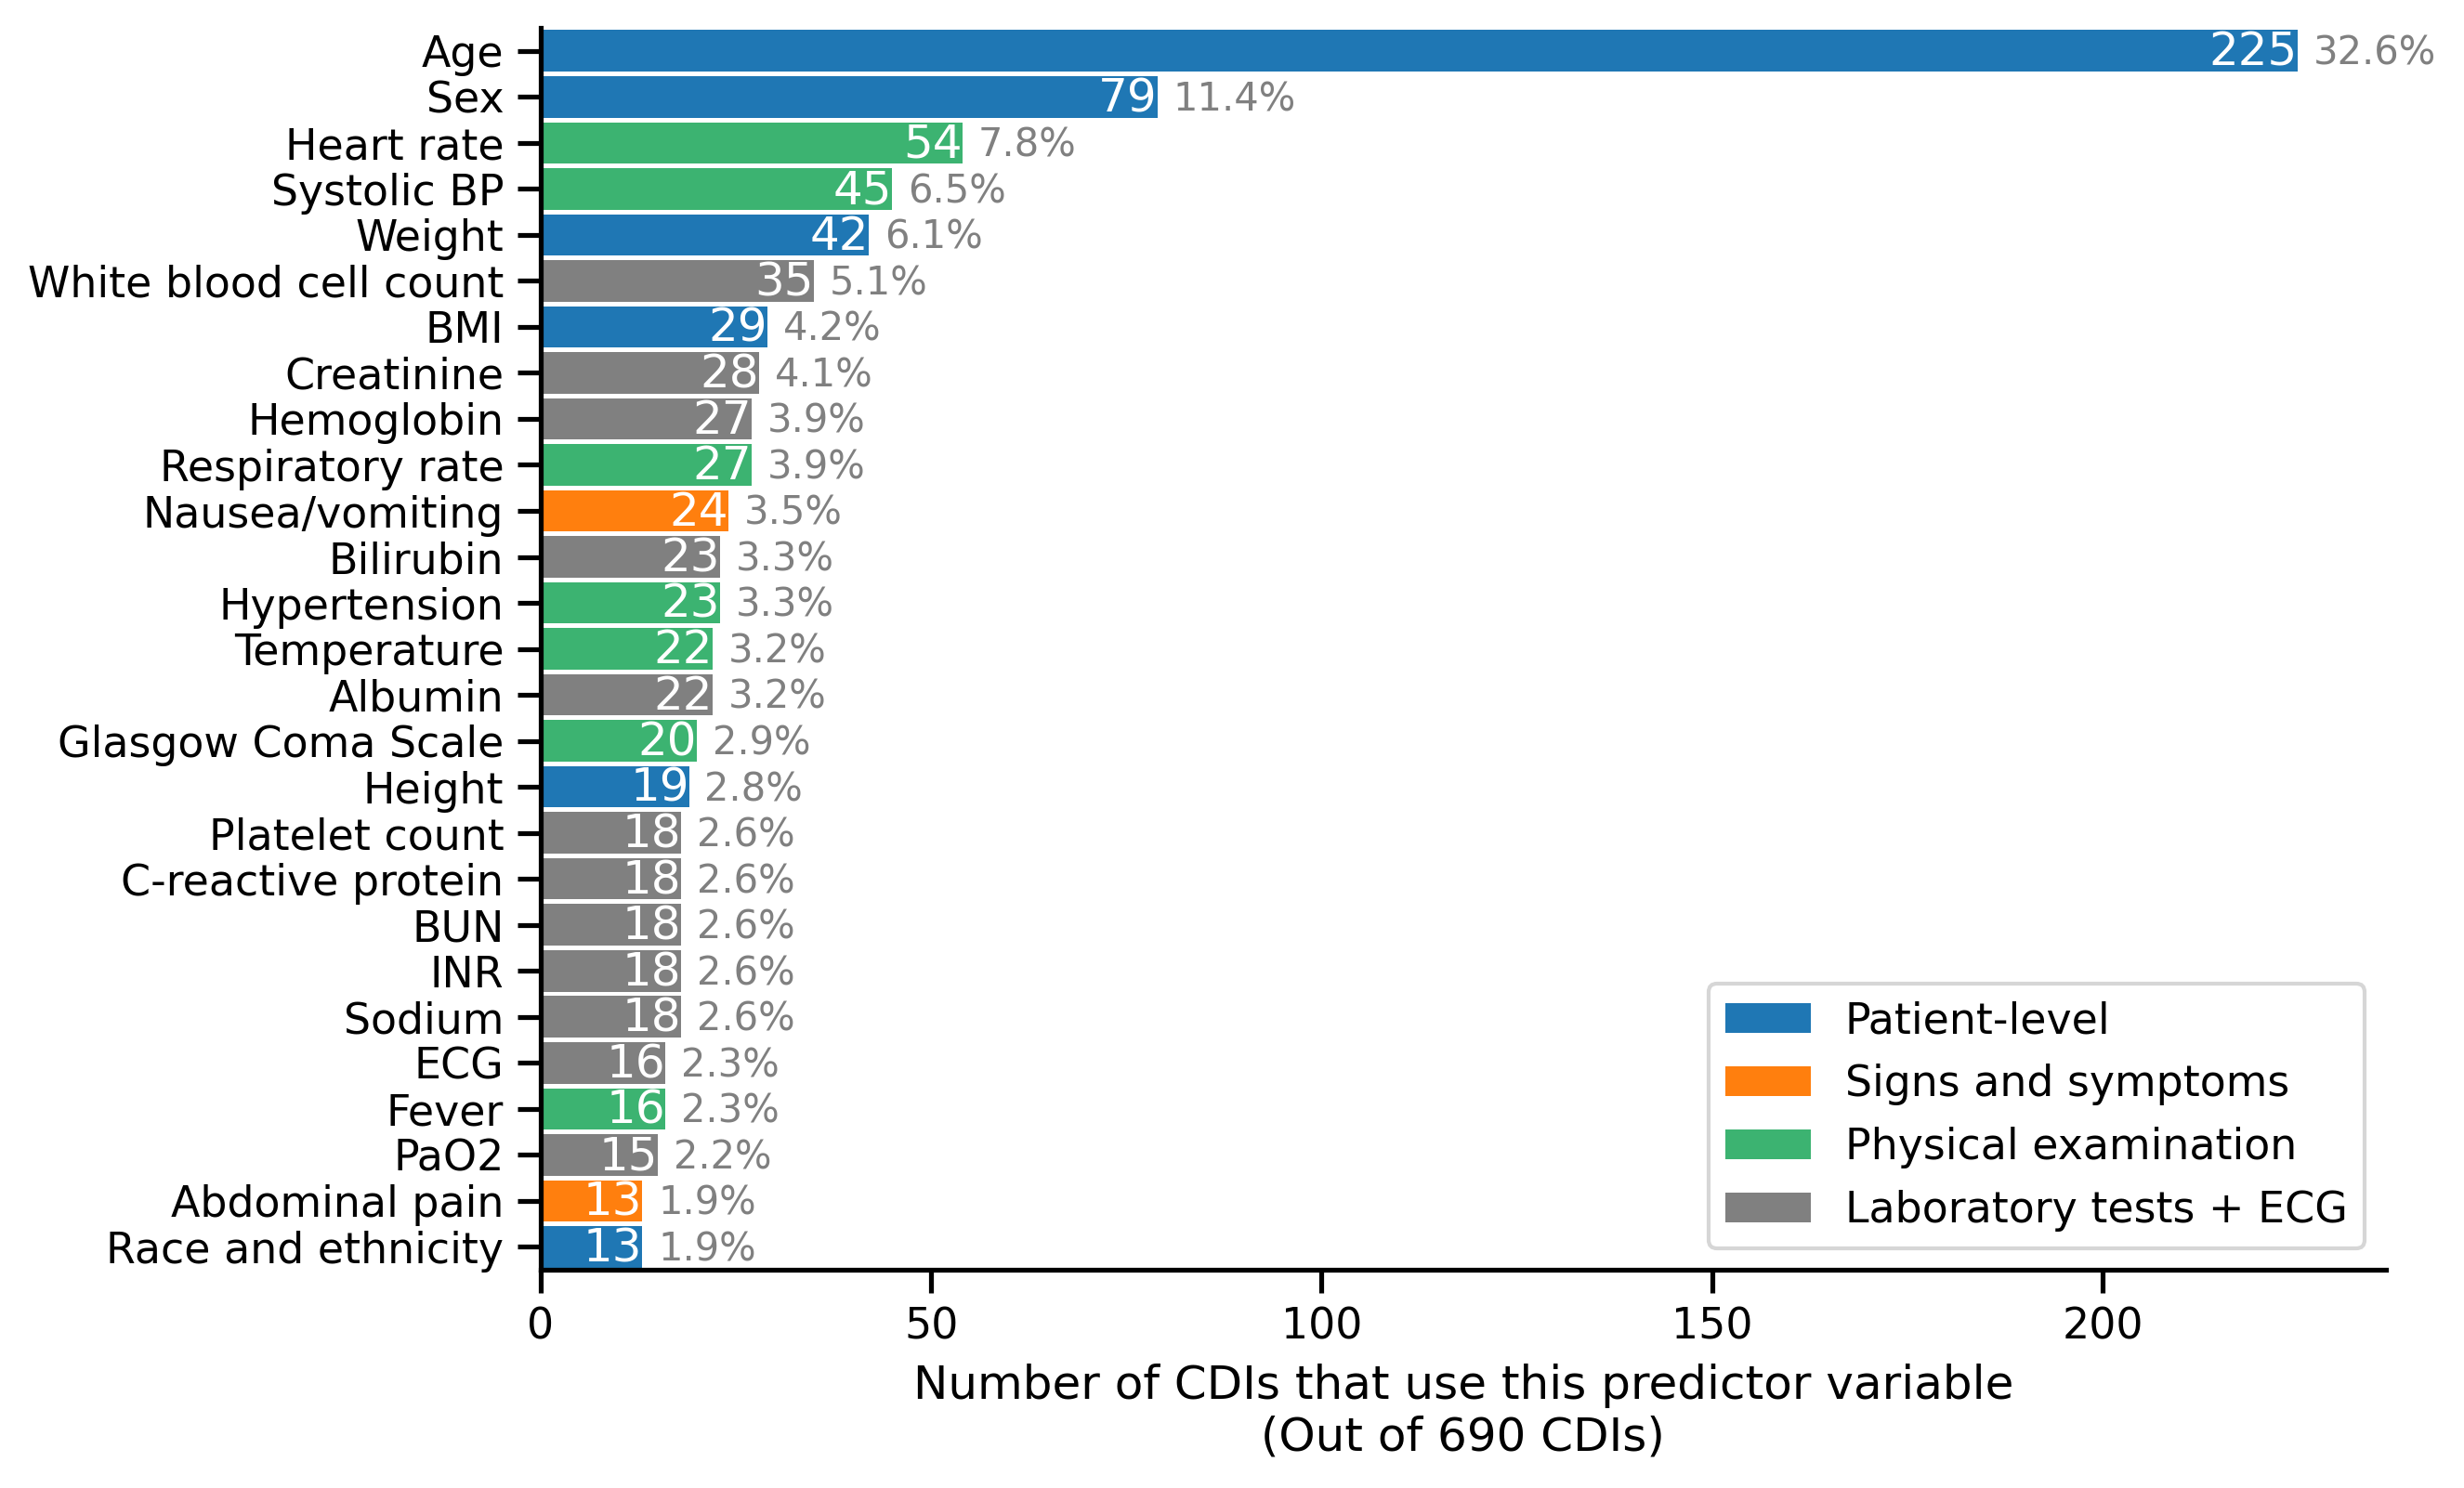

In [27]:
%load_ext autoreload
%autoreload 2


import dvu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from collections import defaultdict

import mdcalc
import viz

# plt.style.use('default')
dvu.set_style()
sns.set_context('notebook')

df = pd.read_pickle('../data/cdis_with_schemas_cleaned.pkl')
df = mdcalc.add_feature_names(df)

# make plot
all_words = sum(df['feature_names_unique'], [])  # concatenate all list
all_words = pd.Series(all_words)
# all_words = all_words[~(all_words == 'unknown')] # not necessary, already handleed
counts = all_words.value_counts()
feat_names = pd.Series(counts.index)

feat_names = feat_names.map(lambda x: x.replace('Sex/Gender', 'Sex').replace('Race/Ethnicity', 'Race and ethnicity'))

counts.head(30)
plt.figure(figsize=(9, 5.5), dpi=300, facecolor='w')
N = 27


# colors
GROUPING = {
    'Patient-level': ['Age', 'Sex', 'Weight', 'BMI', 'Race and ethnicity', 'Height',],
    'Signs and symptoms': ['Nausea/vomiting', 'Abdominal pain'],
    'Physical examination': ['Heart rate', 'Systolic BP', 'Respiratory rate', 'Hypertension', 'Fever', 'Temperature', 'Glasgow Coma Scale',],
    'Laboratory tests + ECG': ['White blood cell count', 'Creatinine', 'Hemoglobin',  'Bilirubin', 'Albumin',  'Platelet count', 'INR', 'C-reactive protein', 'BUN', 'Sodium', 'PaO2', 'ECG'],
    # 'Other diagnostics': [, ]
}
colors = ['C0', 'C1', 'mediumseagreen', 'gray']
GROUPING_COLORS = {k: colors[i] for i, k in enumerate(GROUPING.keys())}
color_assignments = []
for feat_name in feat_names:
    for group_name, group_feats in GROUPING.items():
        if feat_name in group_feats:
            color_assignments.append(GROUPING_COLORS[group_name])
            break
    else:
        color_assignments.append('lightgray')

plt.barh(feat_names[:N][::-1], counts.values[:N][::-1], color=color_assignments[:N][::-1], height=0.9)
plt.ylim(-0.5, N - 0.5)

ax = plt.gca()
texts = [str(x) for x in counts.values[:N][::-1]]
for i, p in enumerate(ax.patches):
    ax.annotate(texts[i], (p.get_width(), p.get_y() + 0.13), ha='right', color='white')
texts_perc = [f'{100 * x/df.shape[0]:.1f}%' for x in counts.values[:N][::-1]]
for i, p in enumerate(ax.patches):
    ax.annotate(texts_perc[i], (p.get_width() + 2, p.get_y() + 0.15), ha='left', color='gray', fontsize='small')
plt.xlabel(f'Number of CDIs that use this predictor variable\n(Out of {df.shape[0]} CDIs)')


# add legend
for group_name, color in GROUPING_COLORS.items():
    plt.barh(['White blood cell count'], 1, color=color, label=group_name)
# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.legend()

plt.tight_layout()
viz.savefig('common_features')

min and max: 1 48


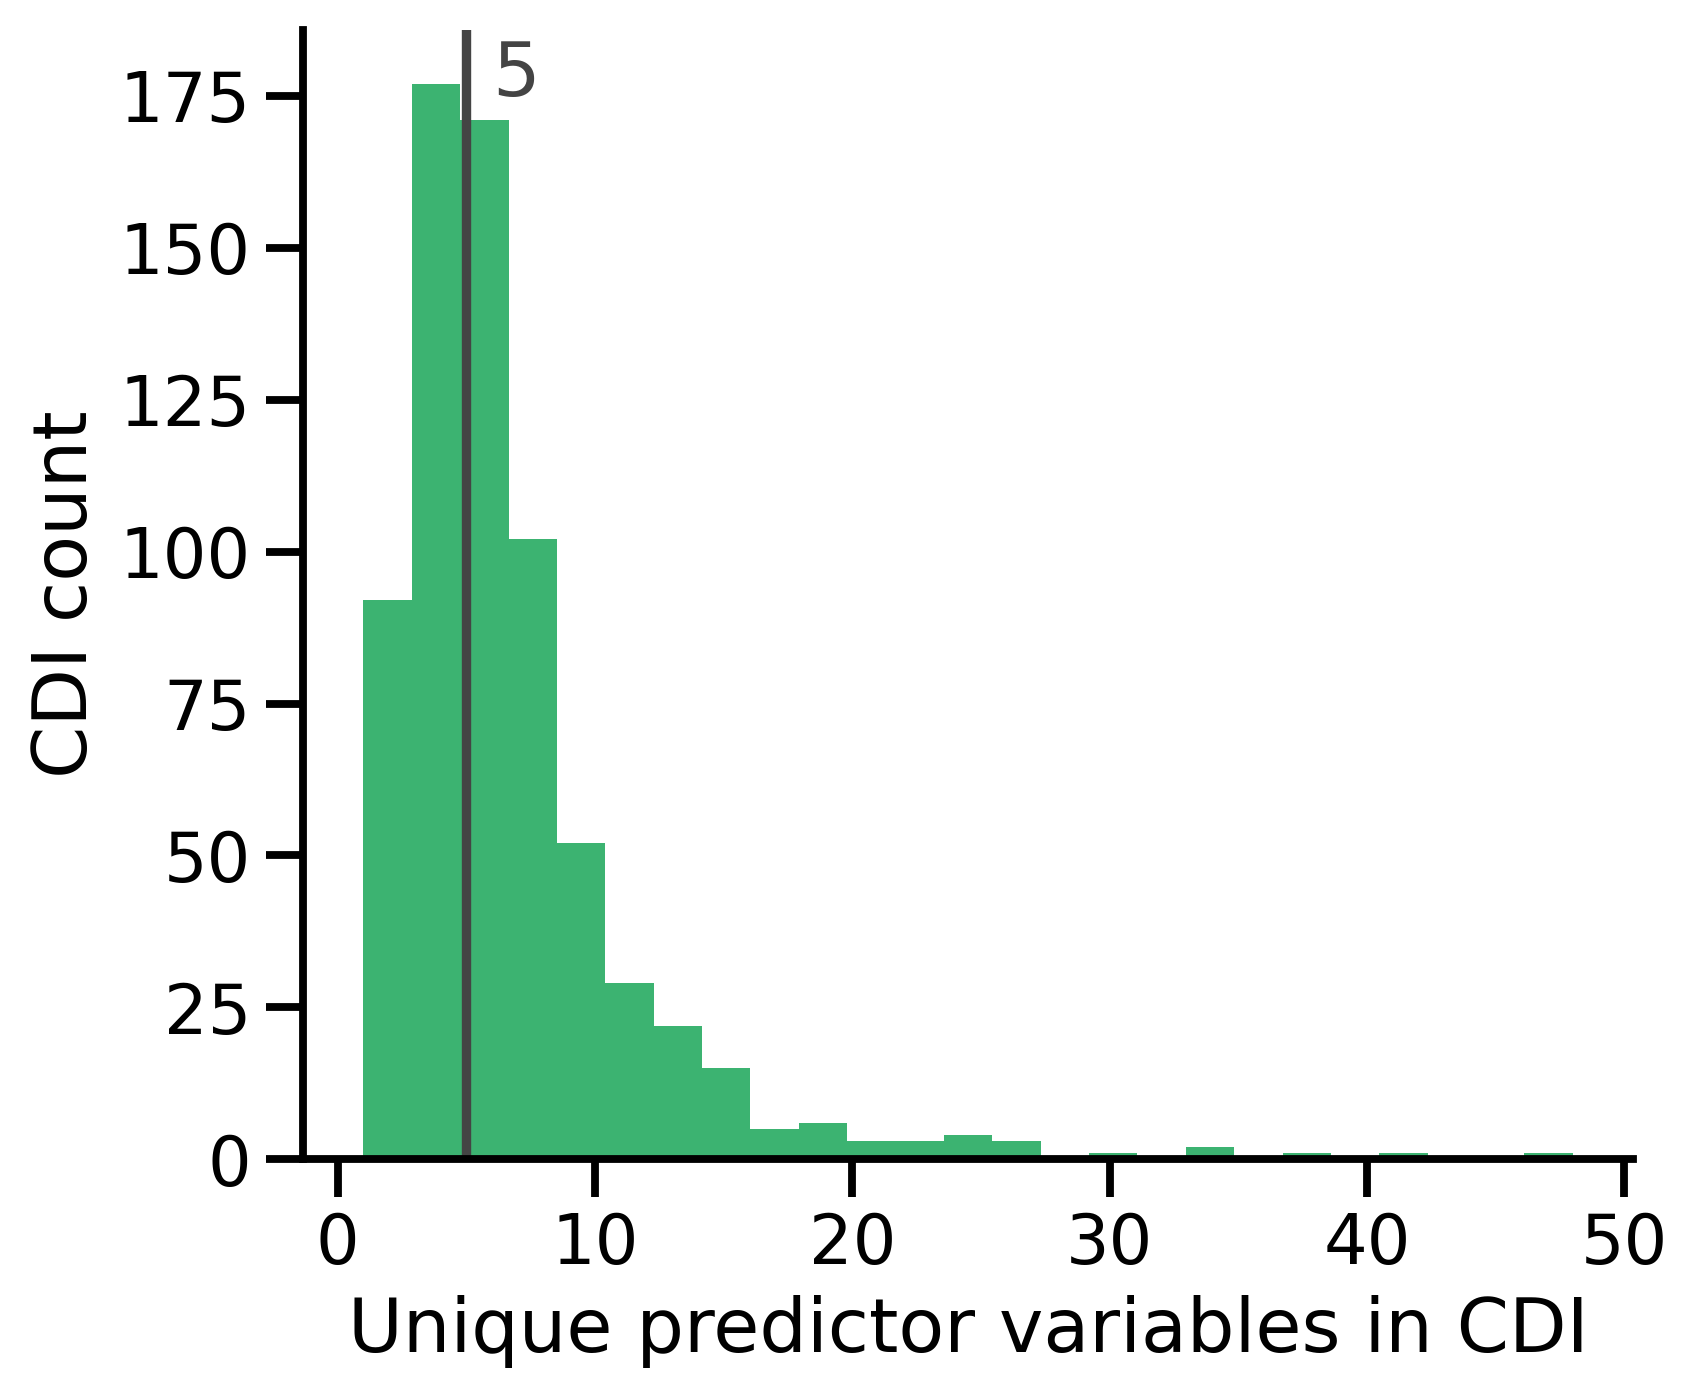

In [2]:
# df['num_splits'] = df['feature_names'].apply(len)
sns.set_context('talk')
plt.figure(dpi=300, facecolor='w', figsize=(6, 5))
# plt.hist(df['num_splits'], label='Splits in CDI', bins=25)
avg = np.median(df['num_features_unique'])
plt.axvline(x=avg, ls='-', color='#444')
plt.text(s=f'{avg:0.0f}', x=avg + 1, y=175, color='#444')
plt.hist(df['num_features_unique'], bins=25,
         color='mediumseagreen')  # , alpha=0.8)
plt.xlabel('Unique predictor variables in CDI')
# plt.ylabel(f'Count of CDIs\n(out of {df.shape[0]} CDIs)')
plt.ylabel('CDI count')
# plt.title('B', loc='left', fontsize='x-large', fontweight='bold')
plt.tight_layout()
print('min and max:', df['num_features_unique'].min(),
      df['num_features_unique'].max())

# plt.legend()
viz.savefig('num_rules_hist')
# plt.show()

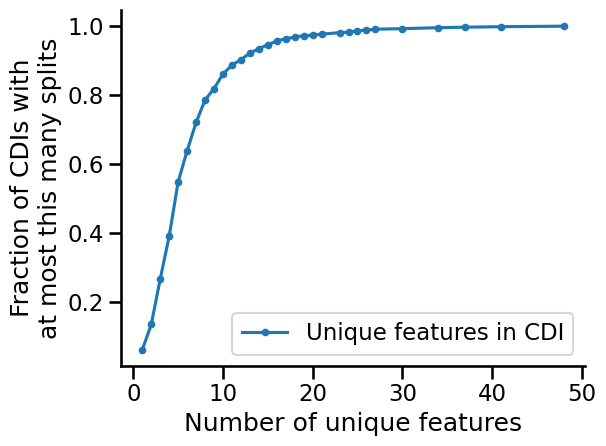

In [3]:
# vals, counts = np.unique(df['num_splits'], return_counts=True)
# plt.plot(vals, np.cumsum(counts) / np.sum(counts), '.-', label='Splits in CDI')
# val_90 = (np.cumsum(counts) / np.sum(counts)) >= 0.9

# plt.show()
vals, counts = np.unique(df['num_features_unique'], return_counts=True)
plt.plot(vals, np.cumsum(counts) / np.sum(counts),
         '.-', label='Unique features in CDI')

plt.xlabel('Number of unique features')
plt.ylabel('Fraction of CDIs with\nat most this many splits')
plt.legend()
viz.savefig('num_rules_cdf')
plt.show()

# Feature analysis

only keeping 310 CDIs out of 690


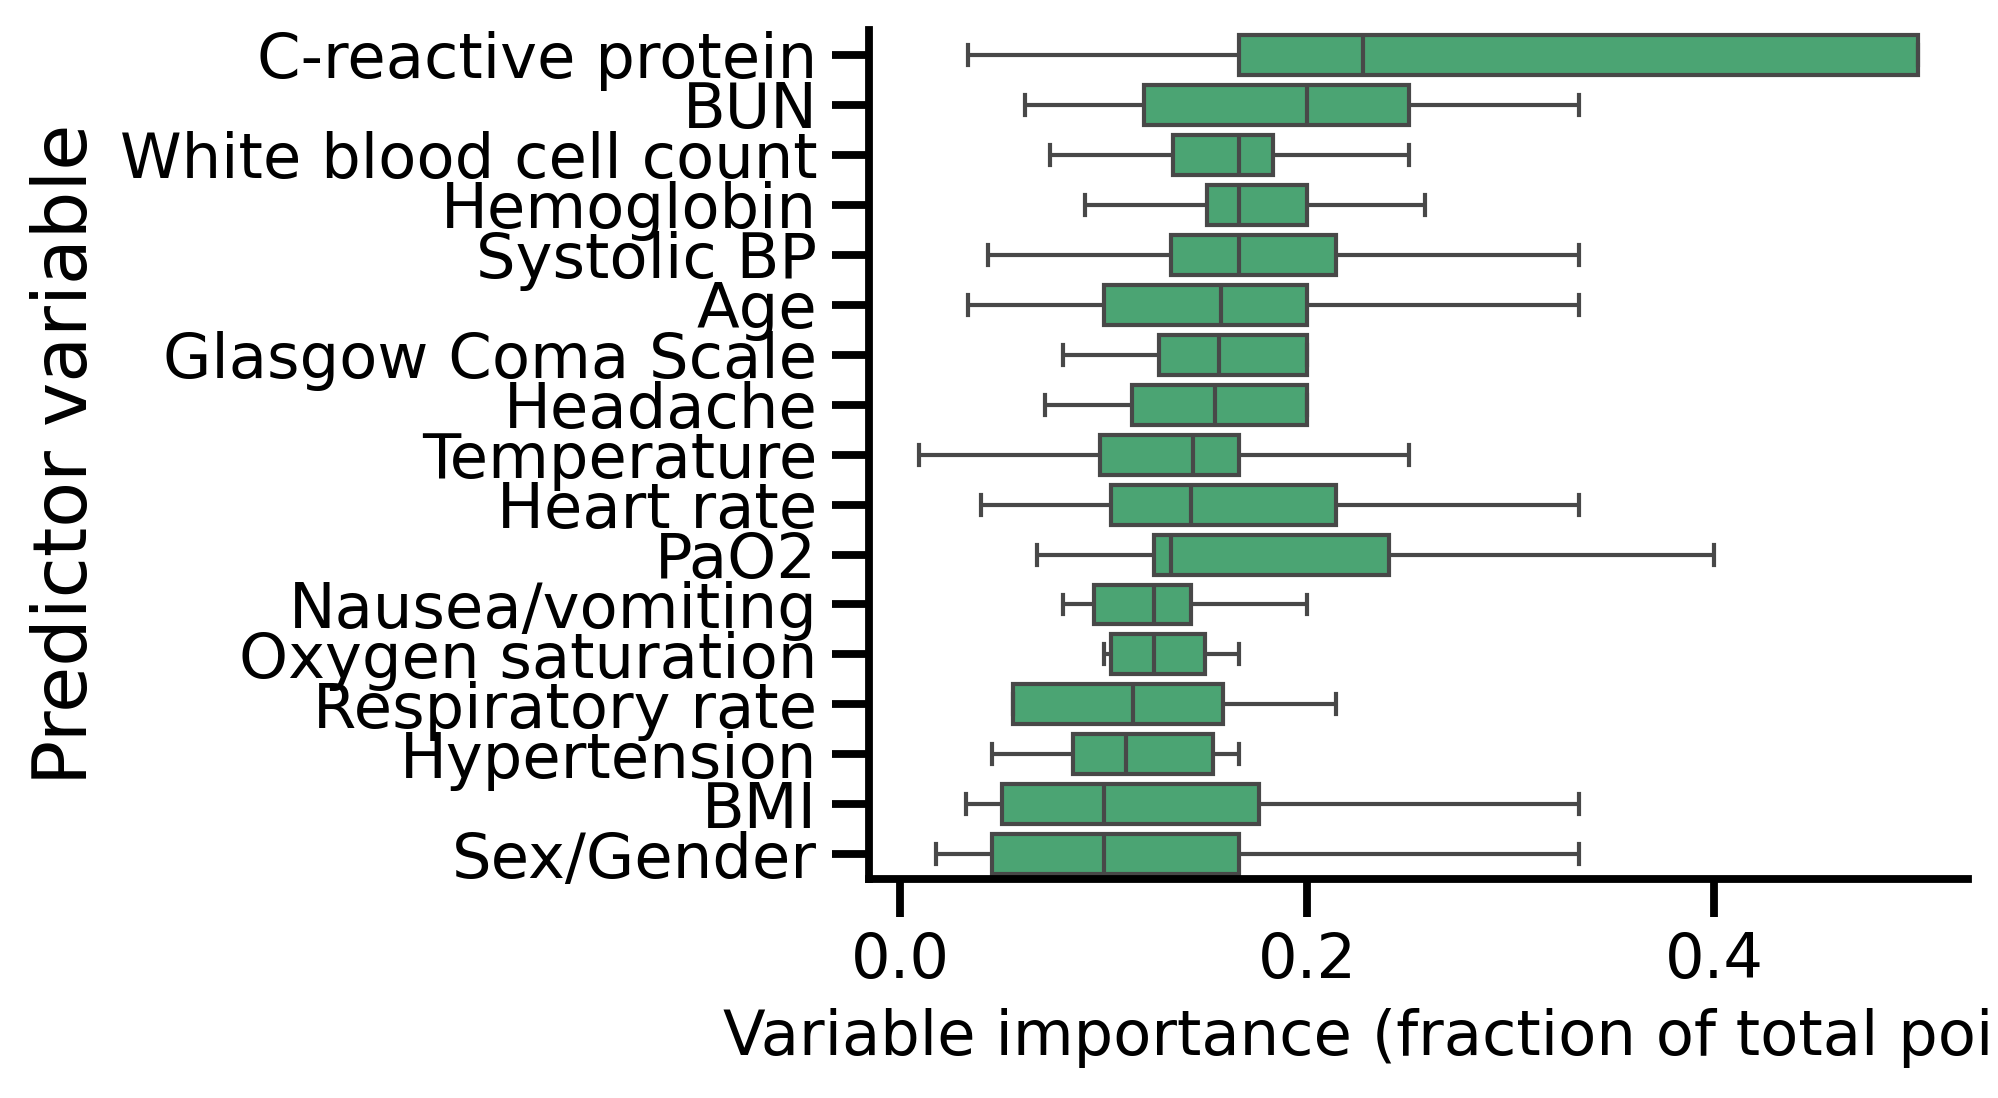

In [4]:
# only keep scoring-only CDIs
feature_score_tuples_list = df["feature_score_tuples_list"][
    df["feature_score_tuples_list"].apply(len) > 0
]
print("only keeping",
      feature_score_tuples_list.shape[0], "CDIs out of", df.shape[0])

# get score_dict
score_tuples = sorted(sum(feature_score_tuples_list, []), key=lambda x: x[0])
ks = sorted(set([score_tuple[0] for score_tuple in score_tuples]))
score_dict = defaultdict(list)
for key, score in score_tuples:
    score_dict[key].append(score)

# filter list
scores_list = [
    (k, v)
    for (k, v) in score_dict.items()
    if len(v) >= 9
    # or k == 'Race/Ethnicity'
]
# scores_list = sorted(score_dict_filt, key=lambda x: len(x[1]), reverse=True)

# format into df
feat_name_vec = sum([[k] * len(v) for (k, v) in scores_list], [])
score_vec = sum([v for (k, v) in scores_list], [])
df_box = pd.DataFrame.from_dict(
    {"feat_name": feat_name_vec, "score": score_vec})
medians = df_box.groupby(["feat_name"])[
    "score"].median().sort_values(ascending=False)

# plot
plt.figure(dpi=300, figsize=(7, 4))
# place grid in background behind other elements
sns.boxplot(
    x="score",
    y="feat_name",
    data=df_box,
    color="mediumseagreen",
    order=medians.index,
    # fliersize=3.1,
    whis=1.5,
    showfliers=False,

    # change color of fliers
    # flierprops=dict(alpha=1, marker='o', color='#EEE'),
)
plt.ylabel("Predictor variable")
plt.yticks(fontsize="small")
plt.xticks(fontsize="small")
plt.xlabel(
    "Variable importance (fraction of total points)",
    fontsize="small",
)
# plt.grid(axis="x")
plt.tight_layout()
viz.savefig("scoring_cdi_boxplot")

### Filter CDIs with potentially biased features

In [5]:
def check_fam_hist(x):
    return [s for s in x if "fam" in s.lower() and "history" in s.lower()]


df["fam_hist_var"] = df["feature_names_unique_uncleaned"].apply(check_fam_hist)
fam_hist = df["fam_hist_var"].apply(len) > 0
df['fam_hist_var'] = df['fam_hist_var'].apply(
    lambda x: str(x)[1: -1].replace("'", ""))
print(fam_hist.sum(), "family history CDIs")
d = df[["full_title_en", "short_description_en",
        "ref_text", "fam_hist_var"]][fam_hist].sort_index()
d.to_csv("../results/fam_hist_cdis.csv", index=False)
with pd.option_context("display.max_colwidth", None):
    display(d)

10 family history CDIs


,full_title_en,short_description_en,ref_text,fam_hist_var
13,ACC/AHA Heart Failure Staging,Heart failure staging and therapy recommendations.,"Hunt SA, Baker DW et al. ACC/AHA Guidelines for the Evaluation and Management of Chronic Heart Failure in the Adult: Executive Summary A Report of the American College of Cardiology/American Heart Association Task Force on Practice Guidelines (Committee to Revise the 1995 Guidelines for the Evaluation and Management of Heart Failure): Developed in Collaboration With the International Society for Heart and Lung Transplantation; Endorsed by the Heart Failure Society of America. Circulation. 2001 Dec 11;104(24):2996-3007.",Patient with family history of cardiomyopathy
28,ASAS Criteria for Axial Spondyloarthritis (SpA),Axial SpA diagnosis.,"Rudwaleit M, Van Der Heijde D, Landewé R, et al. The development of Assessment of SpondyloArthritis international Society classification criteria for axial spondyloarthritis (part II): validation and final selection. Ann Rheum Dis. 2009;68(6):777-83.",Family history of SpA
29,ASAS Criteria for Peripheral SpondyloArthritis (SpA),Peripheral SpA diagnosis.,"Rudwaleit M, Van der heijde D, Landewé R, et al. The Assessment of SpondyloArthritis International Society classification criteria for peripheral spondyloarthritis and for spondyloarthritis in general. Ann Rheum Dis. 2011;70(1):25-31.",Positive family history of SpA
113,CASPAR Criteria for Psoriatic Arthritis,Psoriatic arthritis diagnosis.,"Taylor W, Gladman D, Helliwell P, et al. Classification criteria for psoriatic arthritis: development of new criteria from a large international study. Arthritis Rheum. 2006;54(8):2665-73.","Current psoriasis, personal history of psoriasis, or family history of psoriasis"
133,Cambridge Diabetes Risk Score,T2DM risk.,"Griffin SJ, Little PS, Hales CN, Kinmonth AL, Wareham NJ. Diabetes risk score: towards earlier detection of type 2 diabetes in general practice. Diabetes Metab Res Rev. 2000;16(3):164-71.",Family history
140,Caprini Score for Venous Thromboembolism (2005),Stratifies risk of VTE in surgical patients.,"Caprini JA, Arcelus JI, Hasty JH, Tamhane AC, Fabrega F. Clinical assessment of venous thromboembolic risk in surgical patients. Semin Thromb Hemost. 1991;17 Suppl 3:304-12.",Family history of thrombosis
192,Dutch Criteria for Familial Hypercholesterolemia (FH),Diagnoses familial hypercholesterolemia.,"World Health Organization. Familial hypercholesterolemia—report of a second WHO Consultation. Geneva, Switzerland: World Health Organization, 1999. (WHO publication no. WHO/HGN/FH/CONS/99.2).","Patient has elevated cholesterol, family history of FH, and/or family history of premature cardiac death"
213,FINDRISC (Finnish Diabetes Risk Score),T2DM risk.,"Lindström J, Tuomilehto J. The diabetes risk score: a practical tool to predict type 2 diabetes risk. Diabetes Care. 2003;26(3):725-31.",Family history of diabetes
424,Opioid Risk Tool (ORT) for Narcotic Abuse,Risk of narcotic abuse/misuse.,"Webster LR, Webster RM. Predicting aberrant behaviors in opioid-treated patients: preliminary validation of the Opioid Risk Tool. Pain Med. 2005 Nov-Dec;6(6):432-42. PubMed PMID: 16336480.","Family history of illegal drug abuse, Family history of alcohol abuse, Family history of prescription drug abuse"
615,Simon Broome Diagnostic Criteria for Familial Hypercholesterolemia (FH),Diagnoses familial hypercholesterolemia (FH).,Risk of fatal coronary heart disease in familial hypercholesterolaemia. Scientific Steering Committee on behalf of the Simon Broome Register Group. BMJ : British Medical Journal. 1991;303(6807):893-896.,"Family history of premature CVD events, Family history of extremely high cholesterol"


In [6]:
def check_race_ethnicity(x):
    return [s for s in x if mdcalc.rename_feature_name(s) == 'Race/Ethnicity']


df["race_var"] = df["feature_names_unique_uncleaned"].apply(
    check_race_ethnicity)
race = df["race_var"].apply(len) > 0
df['race_var'] = df['race_var'].apply(lambda x: str(x)[1: -1].replace("'", ""))
print(race.sum(), "race CDIs")
d = df[["full_title_en", "short_description_en",
        "ref_text", "race_var"]][race].sort_index()
d.to_csv("../results/race_cdis.csv", index=False)
with pd.option_context("display.max_colwidth", None):
    display(d)

13 race CDIs


,full_title_en,short_description_en,ref_text,race_var
31,ASCVD (Atherosclerotic Cardiovascular Disease) 2013 Risk Calculator from AHA/ACC,10-year heart disease or stroke risk.,"Goff DC Jr, et. al. 2013 ACC/AHA Guideline on the Assessment of Cardiovascular Risk A Report of the American College of Cardiology/American Heart Association Task Force on Practice Guidelines. Circulation. 2014 Jun 24;129(25 Suppl 2):S49-73. doi: 10.1161/01.cir.0000437741.48606.98. Epub 2013 Nov 12.",Race
32,ASCVD (Atherosclerotic Cardiovascular Disease) Risk Algorithm including Known ASCVD from AHA/ACC,10-year heart disease or stroke risk and statin recommendations.,"Goff DC Jr, et. al. 2013 ACC/AHA Guideline on the Assessment of Cardiovascular Risk A Report of the American College of Cardiology/American Heart Association Task Force on Practice Guidelines. Circulation. 2014 Jun 24;129(25 Suppl 2):S49-73. doi: 10.1161/01.cir.0000437741.48606.98. Epub 2013 Nov 12.",Race
75,Australian Type 2 Diabetes Risk (AUSDRISK) Assessment Tool,Estimates diabetes risk.,"Chen L, Magliano DJ, Balkau B, Colagiuri S, Zimmet PZ, Tonkin AM, Mitchell P, Phillips PJ, Shaw JE. AUSDRISK: an Australian Type 2 Diabetes Risk Assessment Tool based on demographic, lifestyle and simple anthropometric measures. Med J Aust. 2010 Feb 15;192(4):197-202.",Ethnicity
122,CKD-EPI Equations for Glomerular Filtration Rate (GFR),Estimates GFR.,"Levey AS, Stevens LA, Schmid CH, et al. A new equation to estimate glomerular filtration rate. Ann Intern Med. 2009;150(9):604-12.",Race
126,COVID-19 Inpatient Risk Calculator (CIRC),Inpatient COVID mortality or severe disease progression.,"Garibaldi BT, Fiksel J, Muschelli J, et al. Patient trajectories among persons hospitalized for covid-19 : a cohort study. Ann Intern Med. Published online September 22, 2020.",White
180,Denver HIV Risk Score,HIV risk screening.,"Haukoos JS, Lyons MS, Lindsell CJ, et al. Derivation and validation of the Denver Human Immunodeficiency Virus (HIV) risk score for targeted HIV screening. Am J Epidemiol. 2012;175(8):838-46.",Race/ethnicity
209,Estimated/Expected Peak Expiratory Flow (Peak Flow),Quantifies asthma severity.,"Knudson RJ, Lebowitz MD, Holberg CJ, Burrows B. Changes in the normal maximal expiratory flow-volume curve with growth and aging. Am Rev Respir Dis. 1983. Jun;127(6):725-34.",Race/ethnicity
241,GWTG-Heart Failure Risk Score,Predicts in-hospital heart failure mortality.,"Peterson PN, et al. Circ Cardiovasc Qual Outcomes. A validated risk score for in-hospital mortality in patients with heart failure from the American Heart Association get with the guidelines program. 2010 Jan;3(1):25-32. doi: 10.1161/CIRCOUTCOMES.109.854877. Epub 2009 Dec 8.",Black race
242,Gail Model for Breast Cancer Risk,Breast CA risk based on demographic and clinical data.,"Gail MH, Brinton LA, Byar DP, Corle DK, Green SB, Shairer C, Mulvihill JJ: Projecting individualized probabilities of developing breast cancer for white females who are being examined annually. J Natl Cancer Inst 81(24):1879-86, 1989","Race/ethnicity, Asian-American sub race"
322,Kinetic Estimated Glomerular Filtration Rate (keGFR),keGFR estimation.,Chen S. Retooling the creatinine clearance equation to estimate kinetic GFR when the plasma creatinine is changing acutely. J Am Soc Nephrol. 2013;24(6):877-88.,Black race


### Output feature rename table

**Look at the renaming**

In [7]:
feats_print = sorted(set(sum(df['feature_names'], [])))
df_print = pd.DataFrame(feats_print, columns=['Original feature'])
df_print['Chandan rename'] = df_print['Original feature'].apply(
    mdcalc.rename_feature_name)
idxs_same = df_print['Chandan rename'] == df_print['Original feature']
df_print['Chandan rename'][idxs_same] = ''
df_print.to_csv('../data/renaming/features.csv', index=False)

/tmp/ipykernel_4522/2741938302.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_print['Chandan rename'][idxs_same] = ''


In [8]:
from mdcalc import (
    KEYWORDS_CONTAIN,
    KEYWORDS_CASED_CONTAIN,
    KEYWORD_PREFIXES,
    KEYWORDS_MAP,
    KEYWORD_PREFIXES_CASED_MAP,
    KEYWORD_RENAME_FINAL_MAP,
)

In [9]:
d = {
    "KEYWORDS_CONTAIN": KEYWORDS_CONTAIN,
    "KEYWORDS_CASED_CONTAIN": KEYWORDS_CASED_CONTAIN,
    "KEYWORD_PREFIXES": KEYWORD_PREFIXES,
    "KEYWORDS_MAP": [f"{k} → {v}" for k, v in KEYWORDS_MAP.items()],
    "KEYWORD_PREFIXES_CASED_MAP": [f"{k} → {v}" for k, v in KEYWORD_PREFIXES_CASED_MAP.items()],
    "KEYWORD_RENAME_FINAL": [f"{k} → {v}" for k, v in KEYWORD_RENAME_FINAL_MAP.items()],
}
n = max(len(v) for v in d.values())
r = pd.DataFrame()
for k, v in d.items():
    r[k] = pd.Series(v)
r.to_csv("../data/renaming/keywords_export.csv", index=False)

### Feature debugging

In [10]:
# example debugging schema
x = df[df.slug == 'cha2ds2-vasc-score-atrial-fibrillation-stroke-risk'].iloc[0]
schema = x['input_schema']
schema
for s in schema:
    options = s['options']
    print(s['name'], mdcalc.clean_feature_name(
        s['label_en']), [opt['value'] for opt in options])

age Age [0, 1, 2]
sex Sex [1, 0]
heart_failure CHF history [0, 1]
hypertension Hypertension history [0, 1]
stroke Stroke/TIA/thromboembolism history [0, 2]
vascular_disease Vascular disease history (prior MI, peripheral artery disease, or aortic plaque) [0, 1]
diabetes Diabetes history [0, 1]


In [11]:
with pd.option_context("display.max_colwidth", 1000):
    # display(df[df["feature_score_tuples_list"].apply(len) == 2].iloc[3][['url_full', 'input_schema']])
    display(df[df["feature_score_tuples_list"].apply(len) == 2]
            [['url_full', 'feature_score_tuples_list']].head())

,url_full,feature_score_tuples_list
248,https://www.mdcalc.com/calc/3311/glasgow-prognostic-score-gps-cancer-outcomes,"[(C-reactive protein, 0.5), (Albumin, 0.5)]"
377,https://www.mdcalc.com/calc/3312/modified-glasgow-prognostic-score-mgps-cancer-outcomes,"[(C-reactive protein, 0.5), (Albumin, 0.5)]"
490,https://www.mdcalc.com/calc/3313/prognostic-index-cancer-outcomes,"[(C-reactive protein, 0.5), (White blood cell count, 0.5)]"
376,https://www.mdcalc.com/calc/3837/modified-fisher-grading-scale-subarachnoid-hemorrhage-sah,"[(Signs/symptoms, 0.6666666666666666), (Intraventricular hemorrhage, 0.3333333333333333)]"
392,https://www.mdcalc.com/calc/3841/multiple-myeloma-international-staging-system-iss,"[(Serum β2 microglobulin, 0.6666666666666666), (Serum Albumin, 0.3333333333333333)]"


In [12]:
with pd.option_context("display.max_colwidth", 1000):
    slug = 'prognostic-index-cancer-outcomes'
    display(
        df[df.slug == slug][
            ["url_full", "input_schema", "feature_score_tuples_list"]
        ].iloc[0]
    )

url_full                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 https://www.mdcalc.com/calc/3313/prognostic-index-cancer-outcomes
input_schema                 [{'type': 'radio', 'name': 'crp', 'default': None, 'show_points': False, 'optional': False, 'conditionality': None, 'tips_en': '', 'label_en': 'CRP', 'option_fhir_rules': None, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 0}, {'label': 'CRP >10 mg/L', 'value': 1}], 'mdcalc_info_concept': None}, {'type': 'radio', 'nam

In [13]:
# display full
with pd.option_context("display.max_colwidth", 1000):
    # display(
    #     df.sort_values(by="num_features_unique", ascending=False)[
    #         ["url_full", "feature_names_unique", "slug", "input_schema"]
    #     ]
    # )
    display(
        df[df["feature_score_tuples_list"].apply(len) == 2][
            ["url_full", "feature_names_unique", "slug", "input_schema"]
        ]
    )

,url_full,feature_names_unique,slug,input_schema
248,https://www.mdcalc.com/calc/3311/glasgow-prognostic-score-gps-cancer-outcomes,"[C-reactive protein, Albumin]",glasgow-prognostic-score-gps-cancer-outcomes,"[{'type': 'radio', 'label_en': 'CRP', 'default': None, 'conditionality': '', 'show_points': False, 'tips_en': '', 'optional': False, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 1}, {'label': 'CRP >10 mg/L', 'value': 2}], 'name': 'crp'}, {'type': 'radio', 'label_en': 'Albumin', 'default': None, 'conditionality': '', 'show_points': False, 'tips_en': '', 'optional': False, 'options': [{'label': 'Albumin <3.5 g/dL (35 g/L)', 'value': 1}, {'label': 'Albumin ≥3.5 g/dL (35 g/L)', 'value': 2}], 'name': 'alb'}]"
377,https://www.mdcalc.com/calc/3312/modified-glasgow-prognostic-score-mgps-cancer-outcomes,"[C-reactive protein, Albumin]",modified-glasgow-prognostic-score-mgps-cancer-outcomes,"[{'type': 'radio', 'name': 'crp', 'default': None, 'show_points': False, 'optional': False, 'conditionality': '', 'tips_en': '', 'label_en': 'CRP', 'option_fhir_rules': None, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 1}, {'label': 'CRP >10 mg/L', 'value': 2}], 'mdcalc_info_concept': None}, {'type': 'radio', 'name': 'alb', 'default': None, 'show_points': False, 'optional': False, 'conditionality': '', 'tips_en': '', 'label_en': 'Albumin', 'option_fhir_rules': None, 'options': [{'label': 'Albumin <3.5 g/dL (35 g/L)', 'value': 1}, {'label': 'Albumin ≥3.5 g/dL (35 g/L)', 'value': 2}], 'mdcalc_info_concept': None}]"
490,https://www.mdcalc.com/calc/3313/prognostic-index-cancer-outcomes,"[White blood cell count, C-reactive protein]",prognostic-index-cancer-outcomes,"[{'type': 'radio', 'name': 'crp', 'default': None, 'show_points': False, 'optional': False, 'conditionality': None, 'tips_en': '', 'label_en': 'CRP', 'option_fhir_rules': None, 'options': [{'label': 'CRP ≤10 mg/L', 'value': 0}, {'label': 'CRP >10 mg/L', 'value': 1}], 'mdcalc_info_concept': None}, {'type': 'radio', 'name': 'wbc', 'default': None, 'show_points': False, 'optional': False, 'conditionality': None, 'tips_en': '', 'label_en': 'White blood cell count', 'option_fhir_rules': None, 'options': [{'label': 'WBC ≤ 11 x 10⁹/L', 'value': 0}, {'label': 'WBC > 11 x 10⁹/L', 'value': 1}], 'mdcalc_info_concept': None}]"
376,https://www.mdcalc.com/calc/3837/modified-fisher-grading-scale-subarachnoid-hemorrhage-sah,"[Signs/symptoms, Intraventricular hemorrhage]",modified-fisher-grading-scale-subarachnoid-hemorrhage-sah,"[{'type': 'radio', 'label_en': 'Signs/symptoms', 'name': 'sah', 'default': None, 'show_points': False, 'optional': False, 'conditionality': None, 'tips_en': '', 'options': [{'label': 'No SAH present', 'value': 0}, {'label': 'Focal or diffuse thin SAH', 'value': 1}, {'label': 'Focal or diffuse thick SAH', 'value': 2}]}, {'type': 'toggle', 'name': 'ivh', 'conditionality': None, 'optional': False, 'default': None, 'label_en': 'Intraventricular hemorrhage (IVH) present', 'show_points': False, 'tips_en': '', 'options': [{'label': 'No', 'value': 0}, {'label': 'Yes', 'value': 1}]}]"
392,https://www.mdcalc.com/calc/3841/multiple-myeloma-international-staging-system-iss,"[Serum β2 microglobulin, Serum Albumin]",multiple-myeloma-international-staging-system-iss,"[{'type': 'radio', 'label_en': 'Serum β2 microglobulin', 'name': 'micro', 'default': None, 'show_points': False, 'optional': False, 'conditionality': '', 'tips_en': '', 'options': [{'label': '<3.5 mg/L', 'value': 1}, {'label': '3.5 - 5.4 mg/L', 'value': 2}, {'label': '>5.4 mg/L', 'value': 3}]}, {'type': 'radio', 'label_en': 'Serum Albumin', 'name': 'alb', 'default': None, 'show_points': False, 'optional': False, 'conditionality': '', 'tips_en': '', 'options': [{'label': '<3.5 g/dL', 'value': 1}, {'label': '≥3.5 g/dL', 'value': 2}]}]"
141,https://www.mdcalc.com/calc/3903/cardiac-anesthesia-risk-evaluation-score-care,"[Emergency: surgery as soon as diagnosis is made and operating room is available, Patient status]",cardiac-anest